In [27]:
import pandas as pd
import dask.dataframe as dd
import random
import math
from pathlib import Path
import dask
import time
from distributed import Client, get_task_stream, futures_of

In [24]:
c = Client()
client = c

/home/balast/.conda/envs/rbc/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43077 instead
  warnings.warn(


# Generate Trade Files

In [3]:
max_trade_files_per_ns = 200_000
n_paths = 90 # 50_000
n_dates = 120
max_paths_per_partition = 10 # 200

memory_needed_per_row_gb = 138/1024/6_000_000
n_partitions = math.ceil(n_paths/max_paths_per_partition)
min_node_memory_needed_gb = (memory_needed_per_row_gb * n_paths * n_dates / n_partitions) * max_trade_files_per_ns

In [4]:
min_node_memory_needed_gb

5.390625

In [5]:
all_rows = []
n_files_to_create = 3
trade_folder = './row_partitioned_trade_files'

In [6]:
dates = pd.date_range("2021-07-01", freq="3M", periods=n_dates)
for file_no in range(n_files_to_create):
    print(f'Creating File {file_no:03d}')
    for path in range(n_paths):
        for date in dates:
            all_rows.append([date, path, random.random()*200-100]) 
    
    df = pd.DataFrame(all_rows, columns=['date', 'path', 'mtm']).astype({'path': 'int32', 'mtm': 'float64'}).set_index('path')
    df.date = pd.to_datetime(df.date)
    ddf = dd.from_pandas(df, npartitions=n_partitions)
    trade_filepath = f'{trade_folder}/row_partitioned_trade_file_{file_no:03d}.parquet'
    ddf.to_parquet(trade_filepath)

Creating File 000
Creating File 001
Creating File 002


In [7]:
files = sorted(list(Path(trade_folder).glob('*.parquet')))
files

[PosixPath('row_partitioned_trade_files/row_partitioned_trade_file_000.parquet'),
 PosixPath('row_partitioned_trade_files/row_partitioned_trade_file_001.parquet'),
 PosixPath('row_partitioned_trade_files/row_partitioned_trade_file_002.parquet')]

In [8]:
ddfs = [dd.read_parquet(file) for file in files]

In [9]:
massive_ddf = dd.concat(ddfs)

In [10]:
# ddfs[0].to_delayed()

# Easy, dumb approach

In [11]:
%%time
ns_summed_df = massive_ddf.groupby(['date', 'path']).sum()
epe = ns_summed_df.mtm.mask(ns_summed_df.mtm < 0, 0)
epe.name = "EPE"
ene = ns_summed_df.mtm.mask(ns_summed_df.mtm > 0, 0)
ene.name = "ENE"
agg_df = dd.concat([ene, epe], axis=1).groupby('date').agg({"EPE": ["mean"], "ENE": ["mean"]})
agg_df.columns = ["ENE", "EPE"]
final_df = agg_df.compute()
display(final_df.shape)
final_df

/home/balast/.conda/envs/rbc/lib/python3.9/site-packages/dask/dataframe/multi.py:1196: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


(120, 2)

CPU times: user 125 ms, sys: 5.57 ms, total: 130 ms
Wall time: 317 ms


,ENE,EPE
date,,
2021-07-31,93.700906,-93.265708
2021-10-31,79.560979,-79.123928
2022-01-31,102.457577,-93.377472
2022-04-30,96.082290,-83.006435
2022-07-31,97.739922,-111.406207
...,...,...
2050-04-30,99.747841,-80.469207
2050-07-31,71.061696,-87.841068
2050-10-31,69.369588,-89.855798


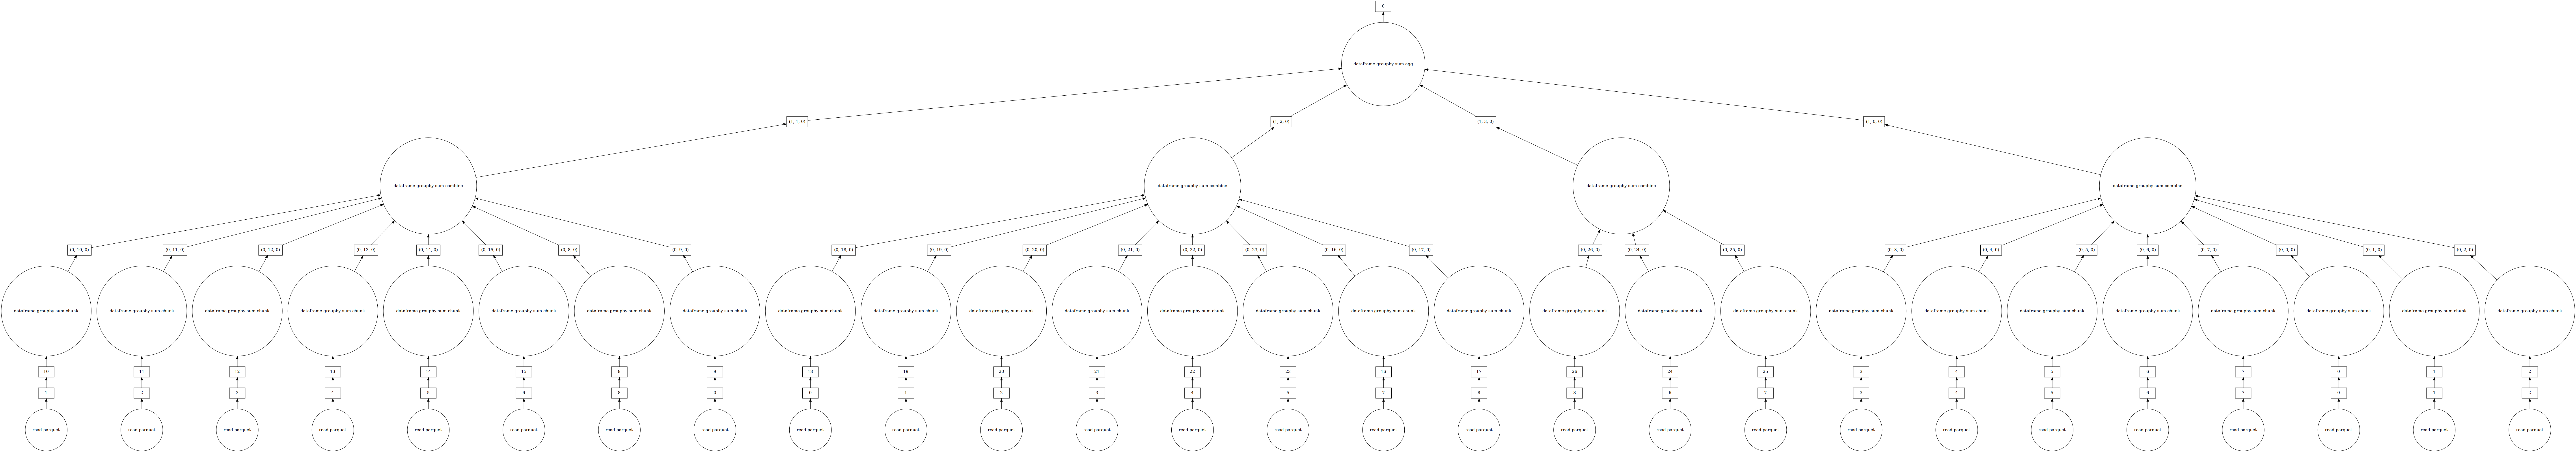

In [16]:
ns_summed_df.visualize()

In [29]:
def dask_timing(func):
    '''get dask.distributed.get_task_stream for worker data on tasks
    '''
    def wrapper(*args, **kwargs):
        start = time.time()
        with get_task_stream() as ts:
            run = func(*args, **kwargs)
        end = time.time()
        ls = []
        print('ts.data', ts.data)
        if ts.data:
            for datum in ts.data:
                d = dict(
                    task_name = func.__name__,
                    worker = datum.get('worker'),
                    status = datum.get('status'),
                    nbytes = datum.get('nbytes'),
                    key = datum.get('key'),
                    type = datum.get('type'),
                    typename = datum.get('typename'),
                    thread = datum.get('thread'),
                    metadata = datum.get('metadata')
                )
                if datum.get('startstops'):
                    for ss in datum['startstops']:
                        ssd = {
                            'action': ss.get('action', np.nan),
                            'start': ss.get('start', np.nan),
                            'stop' : ss.get('stop', np.nan),
                            **d
                        }
                else:
                    ssd=dict(action=np.nan, start=np.nan, stop=np.nan, **d)
                ls.append(ssd)
        if ls:
            df = pd.DataFrame(ls)
            df.name = func.__name__
            df['elapsed'] = df['stop'] - df['start']
            logger.info(f'{df.name} total time: {end-start}')
            logger.info(df.groupby('action')['elapsed'].mean())
            return df,run
        return None, run
    return wrapper

def compute_task(task):
    fut = client.compute(task, retries=3, optimize_graph=False)
    futures = futures_of(fut)
    while not fut.status in ['finished', 'error']:
        sleep(1)
    try:
        assert all(map(lambda x: x.status == 'finished', futures))
    except:
        next(filter(lambda x: x.status == 'error', futures)).result()
    if fut.status != 'finished':
        fut.result()
    # logger.debug(fut.result())
    # fut.cancel()
    return fut

In [39]:
with get_task_stream() as ts:
    ns_summed_df.compute()

[entry['key'] for entry in ts.data]

["('read-parquet-669b5bd33fae07eb7cb8a9e023fb8661', 5)",
 "('read-parquet-fe5f4470edefabec5b27d2d4f00514f9', 7)",
 "('read-parquet-669b5bd33fae07eb7cb8a9e023fb8661', 4)",
 "('read-parquet-669b5bd33fae07eb7cb8a9e023fb8661', 1)",
 "('read-parquet-669b5bd33fae07eb7cb8a9e023fb8661', 3)",
 "('read-parquet-669b5bd33fae07eb7cb8a9e023fb8661', 2)",
 "('read-parquet-fe5f4470edefabec5b27d2d4f00514f9', 8)",
 "('read-parquet-b58a294e65dceb16879fefc7b2329973', 2)",
 "('read-parquet-669b5bd33fae07eb7cb8a9e023fb8661', 0)",
 "('read-parquet-b58a294e65dceb16879fefc7b2329973', 1)",
 "('read-parquet-b58a294e65dceb16879fefc7b2329973', 4)",
 "('read-parquet-b58a294e65dceb16879fefc7b2329973', 7)",
 "('read-parquet-fe5f4470edefabec5b27d2d4f00514f9', 3)",
 "('read-parquet-b58a294e65dceb16879fefc7b2329973', 5)",
 "('read-parquet-b58a294e65dceb16879fefc7b2329973', 0)",
 "('concat-c1e85fab10906c099f6f521a6fb9d3e6', 19)",
 "('concat-c1e85fab10906c099f6f521a6fb9d3e6', 21)",
 "('read-parquet-fe5f4470edefabec5b27d2d4